# Pairwise Spectral EMD Example

Example code to load in events and calculate their pairwise spectral EMDs. Takes about 15 seconds to compile + 30 seconds to run on my laptop, assuming the dataset is already downloaded (Approx 11000 pairs per minute) uing the default presets in this notebook. The more memory, the merrier.

Before using, make sure to `pip install .` in the root directory of this repository.

In [1]:
from pyspecter.SPECTER import SPECTER
from pyshaper.Shaper import Shaper

# Necessary GPU nonsense for SHAPER
import torch 
if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 


# Utils
from particleloader import load
from particleloader.utils import center_and_normalize_zyphi
from rikabplotlib.plot_utils import newplot, plot_event, stamp


# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import time

Using CPU!


# Load Dataset

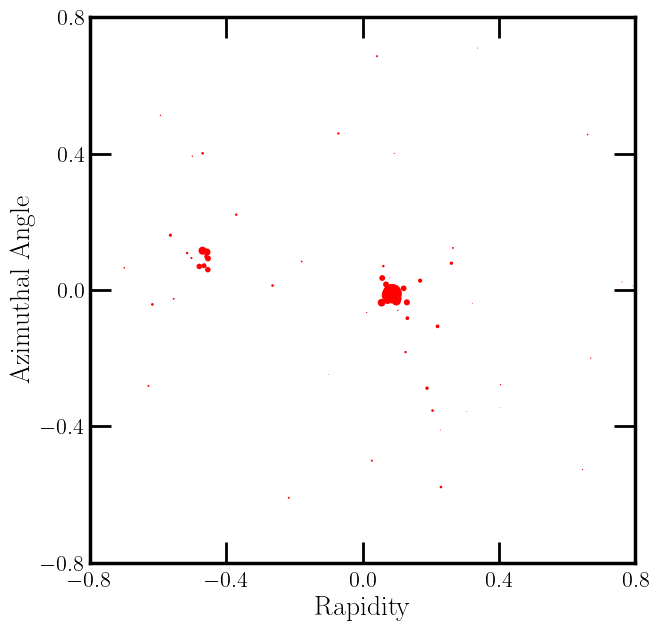

<Axes: xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [2]:
pad = 75 # Note that runtime is pad^2, memory is pad^4
dataset_name = "SPECTER_qcd_jets" # Can also be "SPECTER_top_jets"
cache_dir = "~/.ParticleLoader"

n_samples = 100
batch_size = 1 # Number of pairs to process in parallel, can probably be increased.

# Load data -- this will take a while the first time. Downloads the data from the CMS Open Data portal. Sub in your own data if you have if you want.
data = load(dataset_name, n_samples, cache_dir)[:n_samples, :pad]
data = center_and_normalize_zyphi(data)

# Show an event
fig, ax = newplot("full")
plot_event(ax, data[0], R = 0.8)


# Angularity Observables

In [ ]:
from pyspecter.CommonObservables import build_jet_observables
import jax

R = 1.0
jet_observables_dict = build_jet_observables(R = R)


epochs = 50
lr = 0.005

observable = jet_observables_dict["1-sPronginess"]

observable.is_trivial = False
semds, sparams, sloss_history, sparams_history = observable.compute(data, learning_rate= lr, early_stopping=150, N_sample = 125, finite_difference=False, epochs = epochs)
xemds, params, xloss_history, xparams_history = observable.compute_cross(data, learning_rate= lr, early_stopping=150, N_sample = 125, finite_difference=False, epochs = epochs)

observable.is_trivial = True  

def initialize(events, N, seed):

    centered_events = np.zeros((n_samples, 1, 3))
    centered_events[:,:,0] = 1.0
    return {"Points" : centered_events}

observable.initializer = initialize
observable.compile()

xemds2, params2, xloss_history2, xparams_history2 = observable.compute_cross(data, learning_rate= lr, early_stopping=150, N_sample = 125, finite_difference=False, epochs = epochs)




2025-05-13 21:22:40.558926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
1-sPronginess: Epoch 0 of 50, Mean Loss:  9.244e-02, Time:  2.494s ( 2.494s), Early Stopping:  0.000
1-sPronginess: Epoch 1 of 50, Mean Loss:  9.244e-02, Time:  2.672s ( 0.178s), Early Stopping:  0.000
1-sPronginess: Epoch 2 of 50, Mean Loss:  9.244e-02, Time:  2.757s ( 0.085s), Early Stopping:  0.000
1-sPronginess: Epoch 3 of 50, Mean Loss:  9.244e-02, Time:  2.833s ( 0.075s), Early Stopping:  0.000
1-sPronginess: Epoch 4 of 50, Mean Loss:  9.244e-02, Time:  2.910s ( 0.077s), Early Stopping:  0.000
1-sPronginess: Epoch 5 of 50, Mean Loss:  9.244e-02, Time:  2.989s ( 0.079s), Early Stopping:  0.000
1-sPronginess: Epoch 6 of 50, Mean Loss:  9.244e-02, Time:  3.069s ( 0.080s), Early Stopping:  0.000
1-sPronginess: Epoch 7 of 50, Mean Loss:  9.244e-02, Time:  3.150s ( 0.081s), Early Stopping:  0.000
1-sProngines

In [ ]:
import jax 
from pyspecter.SpectralEMD_Helper import cross_ds2_events1_events2

centered_events = np.zeros((n_samples, 1, 3))
centered_events[:,:,0] = 1.0

vmapped_cross = jax.vmap(cross_ds2_events1_events2, in_axes=(0, 0))
crossed = vmapped_cross(centered_events, data) / 2

[ 1.          0.09192161 -0.02401697] [ 1.          0.09192161 -0.02401697]


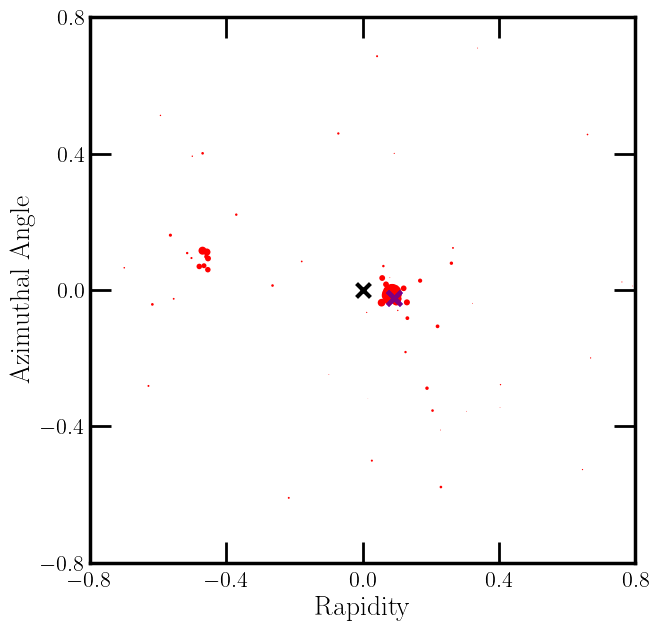

In [ ]:
fig, ax = newplot("full")
ax = plot_event(ax, data[0], R = 0.8, show=False)


ax.scatter((0.0,), (0.0,), s = 100, color = "black", label = "Center of Mass", marker=  "x", zorder = 10)

point1 = sparams_history[0]["Points"][0][0]
point2 = sparams_history[-1]["Points"][0][0]

print(point1, point2)

ax.scatter(point1[1], point1[2], s = 100, color = "blue", label = "k_T", marker=  "x", zorder = 10)
ax.scatter(point2[1], point2[2], s = 100, color = "Purple", label = "X-EMD", marker=  "x", zorder = 10)

# print(xparams_history)





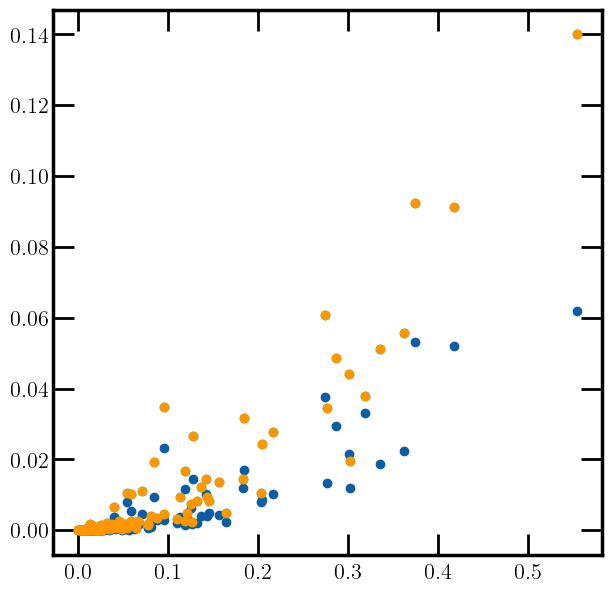

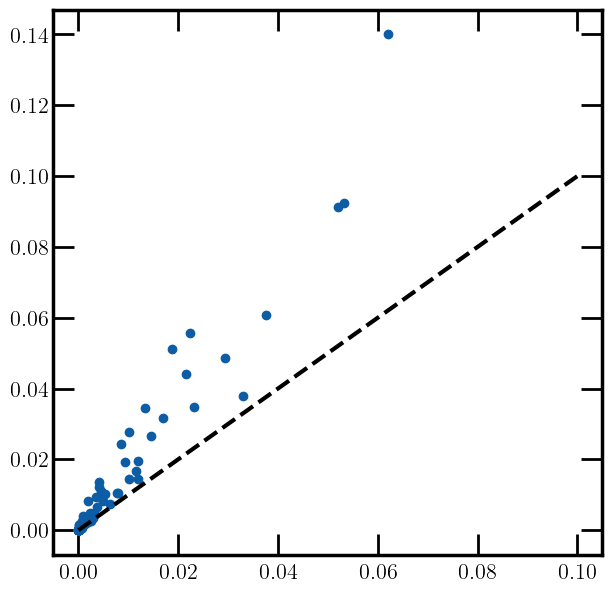

In [ ]:
fig, ax = newplot("full")
ax.plot(semds, xemds, 'o')
ax.plot(semds, crossed, 'o')
ax.plot(semds, xemds2, 'o')

fig, ax = newplot("full")
ax.plot(xemds, crossed, 'o')
ax.plot(np.linspace(0, 0.1, 100), np.linspace(0, 0.1, 100), 'k--')

# Isotropy Observables


In [ ]:
from pyspecter.CommonObservables import build_event_observables


pad = 75 # Note that runtime is pad^2, memory is pad^4
dataset_name = "SPECTER_ee_dijets" # Can also be "SPECTER_top_jets"
cache_dir = "~/.ParticleLoader"

n_samples = 100
batch_size = 1 # Number of pairs to process in parallel, can probably be increased.

# Load data -- this will take a while the first time. Downloads the data from the CMS Open Data portal. Sub in your own data if you have if you want.
dataset_open = load(dataset_name, n_samples, cache_dir)[:n_samples, :pad]


# Normalize such that each event has an energy of 1
dataset_open[:, :, 1] /= np.sum(dataset_open[:, :, 0], axis=-1)[:, None]
dataset_open[:, :, 2] /= np.sum(dataset_open[:, :, 0], axis=-1)[:, None]
dataset_open[:, :, 3] /= np.sum(dataset_open[:, :, 0], axis=-1)[:, None]
dataset_open[:, :, 0] /= np.sum(dataset_open[:, :, 0], axis=-1)[:, None]


event_observables_dict = build_event_observables()

observable = event_observables_dict["spIsotropy"]
semds, sparams, sloss_history, sparams_history = observable.compute(dataset_open, learning_rate= lr, early_stopping=150, N_sample = 125, finite_difference=False, epochs = epochs)
xemds, params, xloss_history, xparams_history = observable.compute_cross(dataset_open, learning_rate= lr, early_stopping=150, N_sample = 125, finite_difference=False, epochs = epochs)



Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit
Compiling with vmap after jit


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([14., 17., 41., 18., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.02      , 0.04      , 0.06      , 0.08      ,
        0.1       , 0.12      , 0.14      , 0.16      , 0.18000001,
        0.2       , 0.22      , 0.23999999, 0.25999999, 0.28      ,
        0.30000001, 0.31999999, 0.34      , 0.36000001, 0.38      ,
        0.40000001, 0.41999999, 0.44      , 0.46000001, 0.47999999,
        0.5       , 0.51999998, 0.54000002, 0.56      , 0.57999998,
        0.60000002, 0.62      , 0.63999999, 0.66000003, 0.68000001,
        0.69999999, 0.72000003, 0.74000001, 0.75999999, 0.77999997,
        0.80000001, 0.81999999, 0.83999997, 0.86000001, 0.88      ,
        0.89999998, 0.92000002, 0.94      , 0.95999998, 0.98000002,
        1.        ]),
 <BarContainer

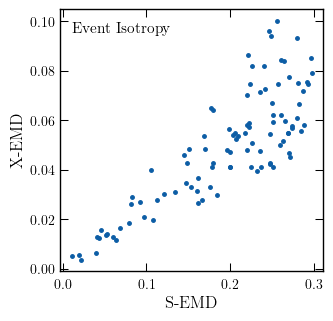

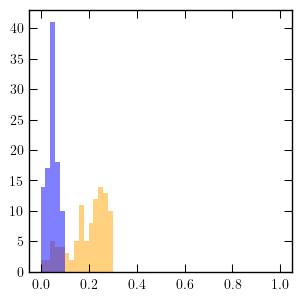

In [ ]:
fig, ax = newplot("column")
plt.plot(semds, xemds, 'o')
plt.xlabel("S-EMD")
plt.ylabel("X-EMD")
plt.legend(title = "Event Isotropy")

fig, ax = newplot("column")
plt.hist(semds, bins = 50, range = (0,1), alpha = 0.5, label = "S-EMD", color = "orange")
plt.hist(xemds, bins = 50, range = (0,1), alpha = 0.5, label = "X-EMD", color = "blue")

# Tests

In [ ]:
from src.pyspecter.SpectralEMD_Helper import compute_double_spectral_representation, compute_cross_spectral_representation, ds2

event1 = np.array([[0.5,0,0],[0.5,0,0]])
event2 = np.array([[0.5,0,1],[0.5,0,1]])

# event1 = data[0]
# event2 = data[1]

# Compute the double spectral representation
double = compute_double_spectral_representation(event1, event2)
print(double[:,1].sum())

# Compute the cross spectral representation
cross = compute_cross_spectral_representation(event1, event2)
print(cross)

# Compute the distance
distance = ds2(double, cross)
print(distance)


2.0
[[1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]]
2.0


# Set up SPECTER

In [ ]:
# Set up and compile SPECTER
specter = SPECTER(compile = True)

# Set up and compile SHAPER
shaper = Shaper({}, device)
shaper.to(device)



Compiling SPECTER model...
Generating test events for tracing ...
Test events generated! Time taken:  2.6453089714050293  seconds.
Compiling spectral representation functions ...
Compiling observables...
Observables compiled! Time taken:  32.14226460456848  seconds.
Compilation complete! Time taken:  32.142273902893066  seconds.


Shaper(
  (observables): ModuleDict()
)

In [ ]:
from src.pyspecter.SpectralEMD_Helper import compute_double_spectral_representation, compute_cross_spectral_representation, ds2

event1 = np.array([[[0.0,0,0],[1.0,0,0]],])
event2 = np.array([[[0.25,0,-1],[0.25,0,1], [0.25,0,2], [0.25,0,-2]],])

# # sample N points with weight 1/N in a circle
# N = 1000
# event2 = np.array([[[1/N, np.cos(2*np.pi * i / N), np.sin(2*np.pi * i / N)] for i in range(N)],])

# event1 = data[0]
# event2 = data[1]

print(specter.crossEMD(event1, event2) / 2)

print(2* shaper.pairwise_emds2(event1, event2, R = 1.0, beta = 2, epsilon = 0.001))


[1.5]
[2.4986136]


# Compute EMDs
Compute the EMDs between every pair of events, in parallel batches of `batch_size` events.

In [ ]:
# Get list of pairwise indices
i_pairs, j_pairs = np.triu_indices(n_samples, k = 1)

# Initialize matrix to store pairwise EMDs
pairwise_emds = np.zeros((n_samples, n_samples))

# Compute batches
start_time = time.time()
for n in range(0, len(i_pairs), batch_size):

    print(f"Computing Batch {n}-{n+batch_size} of {len(i_pairs)} pairs. Elapsed Time: {time.time() - start_time :.3f} seconds")
    i_batch = i_pairs[n : n + batch_size]
    j_batch = j_pairs[n : n + batch_size]
    
    # Compute the pairwise EMDs
    emds = specter.crossEMD(data[i_batch], data[j_batch])
    
    # Store the results
    pairwise_emds[i_batch, j_batch] = emds
    pairwise_emds[j_batch, i_batch] = emds

np.save("pairwise_emds.npy", pairwise_emds)
print(f"Done! Total Elapsed Time: {time.time() - start_time :.3f} seconds")

Computing Batch 0-1 of 4950 pairs. Elapsed Time: 0.000 seconds
Computing Batch 1-2 of 4950 pairs. Elapsed Time: 2.339 seconds
Computing Batch 2-3 of 4950 pairs. Elapsed Time: 2.343 seconds
Computing Batch 3-4 of 4950 pairs. Elapsed Time: 2.346 seconds
Computing Batch 4-5 of 4950 pairs. Elapsed Time: 2.350 seconds
Computing Batch 5-6 of 4950 pairs. Elapsed Time: 2.353 seconds
Computing Batch 6-7 of 4950 pairs. Elapsed Time: 2.356 seconds
Computing Batch 7-8 of 4950 pairs. Elapsed Time: 2.360 seconds
Computing Batch 8-9 of 4950 pairs. Elapsed Time: 2.363 seconds
Computing Batch 9-10 of 4950 pairs. Elapsed Time: 2.366 seconds
Computing Batch 10-11 of 4950 pairs. Elapsed Time: 2.370 seconds
Computing Batch 11-12 of 4950 pairs. Elapsed Time: 2.373 seconds
Computing Batch 12-13 of 4950 pairs. Elapsed Time: 2.377 seconds
Computing Batch 13-14 of 4950 pairs. Elapsed Time: 2.380 seconds
Computing Batch 14-15 of 4950 pairs. Elapsed Time: 2.383 seconds
Computing Batch 15-16 of 4950 pairs. Elapsed

In [ ]:
# Get list of pairwise indices
i_pairs, j_pairs = np.triu_indices(n_samples, k = 1)

# Initialize matrix to store pairwise EMDs
pairwise_semds = np.zeros((n_samples, n_samples))

# Compute batches
start_time = time.time()
for n in range(0, len(i_pairs), batch_size):

    print(f"Computing Batch {n}-{n+batch_size} of {len(i_pairs)} pairs. Elapsed Time: {time.time() - start_time :.3f} seconds")
    i_batch = i_pairs[n : n + batch_size]
    j_batch = j_pairs[n : n + batch_size]
    
    # Compute the pairwise EMDs
    emds = specter.spectralEMD(data[i_batch], data[j_batch])
    
    # Store the results
    pairwise_semds[i_batch, j_batch] = emds
    pairwise_semds[j_batch, i_batch] = emds

np.save("pairwise_semds.npy", pairwise_semds)
print(f"Done! Total Elapsed Time: {time.time() - start_time :.3f} seconds")

Computing Batch 0-1 of 4950 pairs. Elapsed Time: 0.000 seconds
Computing Batch 1-2 of 4950 pairs. Elapsed Time: 1.507 seconds
Computing Batch 2-3 of 4950 pairs. Elapsed Time: 1.509 seconds
Computing Batch 3-4 of 4950 pairs. Elapsed Time: 1.510 seconds
Computing Batch 4-5 of 4950 pairs. Elapsed Time: 1.512 seconds
Computing Batch 5-6 of 4950 pairs. Elapsed Time: 1.513 seconds
Computing Batch 6-7 of 4950 pairs. Elapsed Time: 1.515 seconds
Computing Batch 7-8 of 4950 pairs. Elapsed Time: 1.516 seconds
Computing Batch 8-9 of 4950 pairs. Elapsed Time: 1.518 seconds
Computing Batch 9-10 of 4950 pairs. Elapsed Time: 1.519 seconds
Computing Batch 10-11 of 4950 pairs. Elapsed Time: 1.521 seconds
Computing Batch 11-12 of 4950 pairs. Elapsed Time: 1.522 seconds
Computing Batch 12-13 of 4950 pairs. Elapsed Time: 1.524 seconds
Computing Batch 13-14 of 4950 pairs. Elapsed Time: 1.525 seconds
Computing Batch 14-15 of 4950 pairs. Elapsed Time: 1.527 seconds
Computing Batch 15-16 of 4950 pairs. Elapsed

In [ ]:

# Get list of pairwise indices
i_pairs, j_pairs = np.triu_indices(n_samples, k = 1)

# Initialize matrix to store pairwise EMDs
pairwise_shaper_emds = np.zeros((n_samples, n_samples))

# Compute batches
start_time = time.time()
for n in range(0, len(i_pairs), batch_size):

    print(f"Computing Batch {n}-{n+batch_size} of {len(i_pairs)} pairs. Elapsed Time: {time.time() - start_time :.3f} seconds")
    i_batch = i_pairs[n : n + batch_size]
    j_batch = j_pairs[n : n + batch_size]
    
    # Compute the pairwise EMDs
    emds = shaper.pairwise_emds2(data[i_batch], data[j_batch], R = 1.0, beta = 2, epsilon = 0.001)
    
    # Store the results
    pairwise_shaper_emds[i_batch, j_batch] = emds
    pairwise_shaper_emds[j_batch, i_batch] = emds

np.save("pairwise_shaper_emds.npy", pairwise_shaper_emds)
print(f"Done! Total Elapsed Time: {time.time() - start_time :.3f} seconds")

Computing Batch 0-1 of 4950 pairs. Elapsed Time: 0.000 seconds
Computing Batch 1-2 of 4950 pairs. Elapsed Time: 0.024 seconds
Computing Batch 2-3 of 4950 pairs. Elapsed Time: 0.050 seconds
Computing Batch 3-4 of 4950 pairs. Elapsed Time: 0.091 seconds
Computing Batch 4-5 of 4950 pairs. Elapsed Time: 0.130 seconds
Computing Batch 5-6 of 4950 pairs. Elapsed Time: 0.173 seconds
Computing Batch 6-7 of 4950 pairs. Elapsed Time: 0.212 seconds
Computing Batch 7-8 of 4950 pairs. Elapsed Time: 0.246 seconds
Computing Batch 8-9 of 4950 pairs. Elapsed Time: 0.279 seconds
Computing Batch 9-10 of 4950 pairs. Elapsed Time: 0.320 seconds
Computing Batch 10-11 of 4950 pairs. Elapsed Time: 0.353 seconds
Computing Batch 11-12 of 4950 pairs. Elapsed Time: 0.387 seconds
Computing Batch 12-13 of 4950 pairs. Elapsed Time: 0.421 seconds
Computing Batch 13-14 of 4950 pairs. Elapsed Time: 0.452 seconds
Computing Batch 14-15 of 4950 pairs. Elapsed Time: 0.492 seconds
Computing Batch 15-16 of 4950 pairs. Elapsed

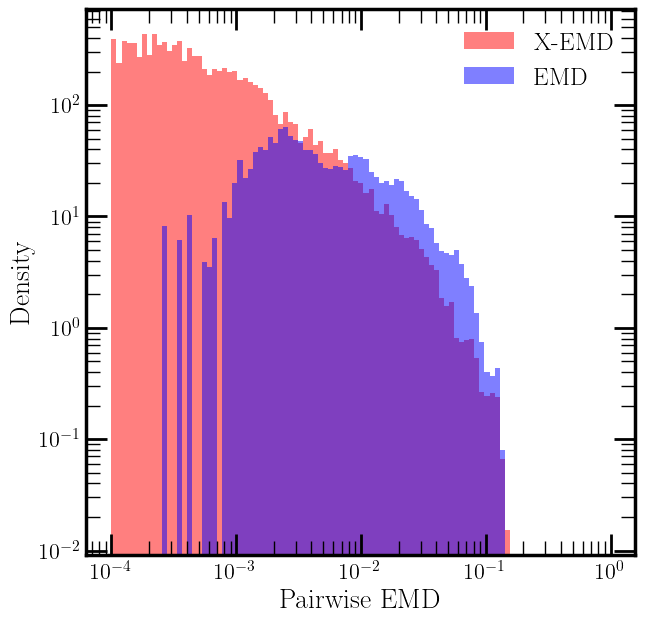

In [ ]:

pairwise_shaper_emds = np.load("pairwise_shaper_emds.npy")


# Histogram the results (upper triangle only)
fig, ax = newplot("full")
plt.hist(pairwise_emds[np.triu_indices(n_samples, k = 1)] / 2, bins = np.logspace(-4,0,100), density=True, label= "X-EMD", color = "red", alpha = 0.5)
plt.hist(pairwise_shaper_emds[np.triu_indices(n_samples, k = 1)] * 2, bins = np.logspace(-4,0,100), density=True, alpha = 0.5, label="EMD", color = "blue")
plt.yscale("log")
plt.xlabel("Pairwise EMD")
plt.ylabel("Density")

plt.xscale("log")

plt.legend()




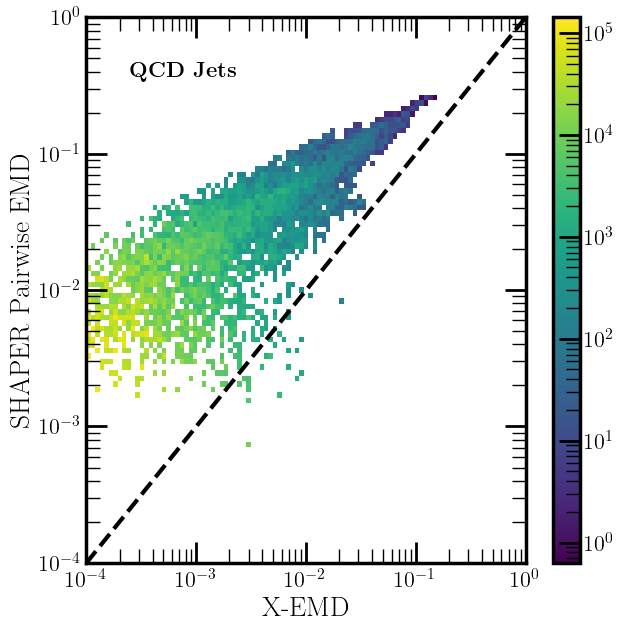

In [ ]:
# 2D histogram of the results
fig, ax = newplot("full")

plt.hist2d(pairwise_emds[np.triu_indices(n_samples, k = 1)]/ 2, pairwise_shaper_emds[np.triu_indices(n_samples, k = 1)] * 2 , bins = np.logspace(-4, 0,100), density=True, norm = plt.cm.colors.LogNorm())
plt.colorbar()
plt.xlabel("X-EMD")
plt.ylabel("SHAPER Pairwise EMD")

plt.plot([0,1], [0,1], ls = "--", color = "black")

plt.xscale("log")
plt.yscale("log")

line0 = "QCD Jets"
stamp(0.1, 0.9, ax, line_0 = line0)





0.883
EMD(i,j) = 0.12600754940789058
EMD(j,k) = 0.08051386189024802
EMD(i,k) = 0.2709413215341297
EMD(i,j) + EMD(j,k) = 0.2065214112981386
EMD(i,k) = 0.2709413215341297
Triangle Inequality:  False


<Axes: xlabel='Rapidity', ylabel='Azimuthal Angle'>

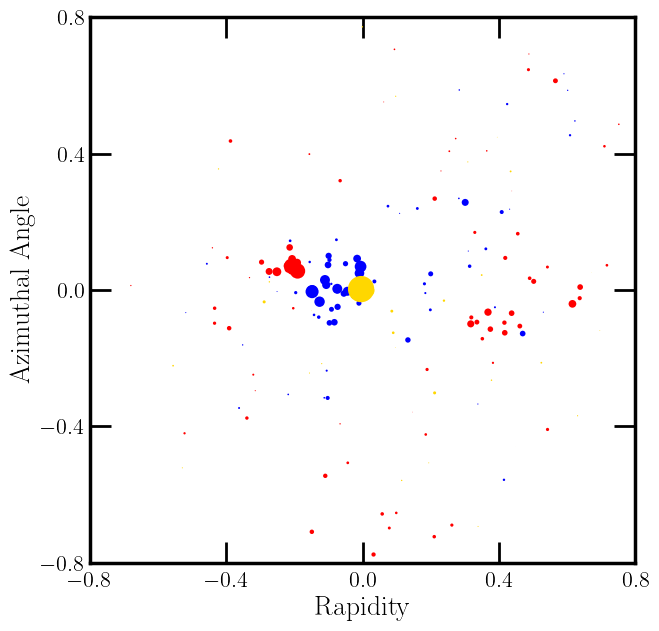

In [ ]:
pairwise_emds = np.load("pairwise_emds.npy")
pairwise_emds = np.sqrt(pairwise_emds)


counts = np.zeros((1000,))

# Take random triplets to check the triangle inequality
for o in range(1000):
    i, j, k = np.random.randint(0, n_samples, 3)

    # print(f"EMD(i,j) = {pairwise_emds[i,j]}")
    # print(f"EMD(j,k) = {pairwise_emds[j,k]}")
    # print(f"EMD(i,k) = {pairwise_emds[i,k]}")

    # print(f"EMD(i,j) + EMD(j,k) = {pairwise_emds[i,j] + pairwise_emds[j,k]}")
    # print(f"EMD(i,k) = {pairwise_emds[i,k]}")
    # print(i, j, k)
    # print("Triangle Inequality: ", pairwise_emds[i,j] + pairwise_emds[j,k] >= pairwise_emds[i,k])

    if pairwise_emds[i,j] + pairwise_emds[j,k] >= pairwise_emds[i,k]:
        counts[o] += 1

print(np.mean(counts))

i = 37 
j = 30
k = 3

print(f"EMD(i,j) = {pairwise_emds[i,j]}")
print(f"EMD(j,k) = {pairwise_emds[j,k]}")
print(f"EMD(i,k) = {pairwise_emds[i,k]}")

print(f"EMD(i,j) + EMD(j,k) = {pairwise_emds[i,j] + pairwise_emds[j,k]}")
print(f"EMD(i,k) = {pairwise_emds[i,k]}")
print("Triangle Inequality: ", pairwise_emds[i,j] + pairwise_emds[j,k] >= pairwise_emds[i,k])


fig, ax = newplot("full")
plot_event(ax, data[i], R = 0.8, show=False, color = "red")
plot_event(ax, data[j], R = 0.8, show=False, color = "blue")
plot_event(ax, data[k], R = 0.8, show=False, color = "gold")


In [ ]:
import jax
import jax.numpy as jnp

def pairwise_metric(a, b):
    """
    Compute pairwise Euclidean distances between rows of a and b.
    
    Args:
        a: jnp.ndarray of shape (n, d)
        b: jnp.ndarray of shape (m, d)
        
    Returns:
        A jnp.ndarray of shape (n, m) where the (i,j)th entry is the 
        Euclidean distance between a[i] and b[j].
    """
    diff = a[:, None, :] - b[None, :, :]
    return jnp.sqrt(jnp.sum(diff ** 2, axis=-1))

def compute_bounds_matrix(points, metric, num_pivots=10, seed=0):
    """
    Given a set of points, compute the lower and upper bound distance matrices
    using a set of randomly chosen pivots.
    
    The lower bound for two points x and y is given by:
       L(x,y) = max_p |d(x, p) - d(y, p)|
       
    The upper bound for two points x and y is given by:
       U(x,y) = min_p [d(x, p) + d(y, p)]
       
    where p ranges over the chosen pivots.
    
    Args:
        points: jnp.ndarray of shape (N, d) -- your data points.
        metric: a function metric(a, b) that computes pairwise distances
                between two arrays a and b.
        num_pivots: number of pivots (landmarks) to use.
        seed: random seed for pivot selection.
    
    Returns:
        A tuple (L, U) where:
         - L is a jnp.ndarray of shape (N, N) containing the lower bound 
           distances.
         - U is a jnp.ndarray of shape (N, N) containing the upper bound 
           distances.
    """
    N, d = points.shape
    key = jax.random.PRNGKey(seed)
    
    # Randomly select num_pivots indices (without replacement)
    pivot_indices = jax.random.choice(key, N, shape=(num_pivots,), replace=False)
    pivots = points[pivot_indices, :]  # shape (num_pivots, d)
    
    # Compute distances from every point to every pivot.
    # D has shape (N, num_pivots)
    D = metric(points, pivots)
    
    # Compute the lower bound matrix:
    # For each pair (i, j), L[i,j] = max_p |D[i, p] - D[j, p]|
    diff = jnp.abs(D[:, None, :] - D[None, :, :])  # shape (N, N, num_pivots)
    L = jnp.max(diff, axis=-1)  # shape (N, N)
    
    # Compute the upper bound matrix:
    # For each pair (i, j), U[i,j] = min_p [D[i, p] + D[j, p]]
    sum_vals = D[:, None, :] + D[None, :, :]  # shape (N, N, num_pivots)
    U = jnp.min(sum_vals, axis=-1)  # shape (N, N)
    
    return L, U

# === Example usage ===
if __name__ == "__main__":
    # Create some random data points.
    N = 100   # number of points
    d = 5     # dimension of each point
    key = jax.random.PRNGKey(42)
    points = jax.random.normal(key, (N, d))
    
    # Use our pairwise_metric (Euclidean) function.
    num_pivots = 10  # you can adjust the number of pivots for a better approximation
    L, U = compute_bounds_matrix(points, pairwise_metric, num_pivots=num_pivots, seed=123)
    
    print("Lower Bound Distance Matrix (L):")
    print(L)
    print("\nUpper Bound Distance Matrix (U):")
    print(U)


Lower Bound Distance Matrix (L):
[[0.        1.9277545 2.0966425 ... 2.216593  1.7158536 1.7000005]
 [1.9277545 0.        2.360024  ... 1.6095657 1.2976701 2.379199 ]
 [2.0966425 2.360024  0.        ... 1.8157016 1.7258638 2.583177 ]
 ...
 [2.216593  1.6095657 1.8157016 ... 0.        1.350591  2.1324716]
 [1.7158536 1.2976701 1.7258638 ... 1.350591  0.        2.1672983]
 [1.7000005 2.379199  2.583177  ... 2.1324716 2.1672983 0.       ]]

Upper Bound Distance Matrix (U):
[[4.6516156 4.573807  4.318946  ... 5.558524  4.8327813 4.0938134]
 [4.573807  3.4691894 3.6700292 ... 3.715917  3.6810904 3.1846848]
 [4.318946  3.6700292 2.4789827 ... 3.7185607 3.3340335 4.4587927]
 ...
 [5.558524  3.715917  3.7185607 ... 3.9626448 3.927818  4.7942505]
 [4.8327813 3.6810904 3.3340335 ... 3.927818  3.8929913 3.4436598]
 [4.0938134 3.1846848 4.4587927 ... 4.7942505 3.4436598 2.7046916]]


N:   100 | num_pivots:  50 | Runtime: 0.00189 sec
N:   200 | num_pivots:  50 | Runtime: 0.00238 sec
N:   500 | num_pivots:  50 | Runtime: 0.00373 sec
N:  1000 | num_pivots:  50 | Runtime: 0.00964 sec
N:  2000 | num_pivots:  50 | Runtime: 0.04575 sec
N:  5000 | num_pivots:  50 | Runtime: 0.32909 sec
Pivot fraction: 0.001 | num_pivots:    1 | Max error: 6.49730
Pivot fraction: 0.005 | num_pivots:    5 | Max error: 4.34475
Pivot fraction: 0.010 | num_pivots:   10 | Max error: 3.68057
Pivot fraction: 0.020 | num_pivots:   20 | Max error: 3.68057
Pivot fraction: 0.050 | num_pivots:   50 | Max error: 3.12500
Pivot fraction: 0.100 | num_pivots:  100 | Max error: 2.93044
Pivot fraction: 0.200 | num_pivots:  200 | Max error: 2.59742
Pivot fraction: 0.500 | num_pivots:  500 | Max error: 1.97296


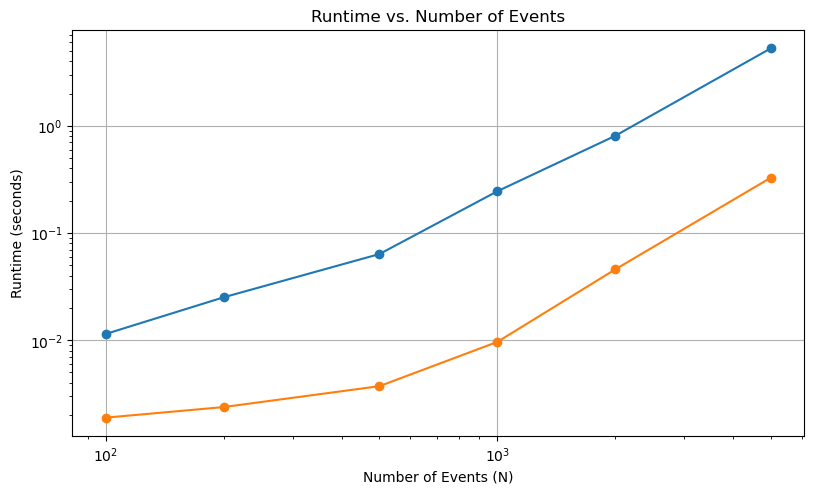

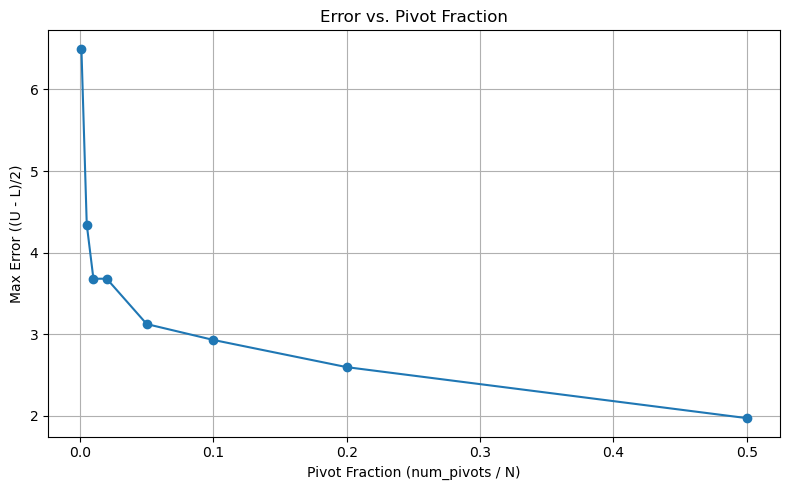

In [ ]:
import time
import matplotlib.pyplot as plt

def experiment_runtime_vs_N():
    """
    Measures the runtime (in seconds) of compute_bounds_matrix as a function
    of the number of points N. Uses a fixed number of pivots.
    """
    Ns = [100, 200, 500, 1000, 2000, 5000]
    runtimes = []
    runtimes_exact = []
    d = 5  # Dimensionality

    # We use a fixed number of pivots (or min(10, N) if N is very small)
    fixed_pivots = 50

    # Warm-up: compile the function once on a small dataset.
    key = jax.random.PRNGKey(0)
    dummy_points = jax.random.normal(key, (50, d))
    _ = compute_bounds_matrix(dummy_points, pairwise_metric, num_pivots=50, seed=123)

    for N in Ns:
        key = jax.random.PRNGKey(42)
        points = jax.random.normal(key, (N, d))
        num_pivots = min(fixed_pivots, N)  # Ensure we don't choose more pivots than points
        
        t0 = time.time()
        L, U = compute_bounds_matrix(points, pairwise_metric, num_pivots=num_pivots, seed=123)
        # Force synchronization to measure the actual runtime.
        L.block_until_ready()
        U.block_until_ready()
        t1 = time.time()
        runtime = t1 - t0
        runtimes.append(runtime)


        t0 = time.time()
        L = jnp.sqrt(pairwise_metric(points, points))
        L.block_until_ready()
        t1 = time.time()
        runtime = t1 - t0
        runtimes_exact.append(runtime)

        print(f"N: {N:5d} | num_pivots: {num_pivots:3d} | Runtime: {runtime:.5f} sec")
    
    plt.figure(figsize=(8, 5))
    plt.plot(Ns, runtimes, marker='o')
    plt.plot(Ns, runtimes_exact, marker='o')
    plt.xlabel("Number of Events (N)")
    plt.ylabel("Runtime (seconds)")
    plt.title("Runtime vs. Number of Events")
    plt.grid(True)
    plt.tight_layout()

    plt.xscale("log")   
    plt.yscale("log")


# --- Experiment 2: Error vs. Pivot Fraction ---

def experiment_error_vs_pivot_fraction():
    """
    For a fixed number of points N, varies the ratio (num_pivots / N) and computes
    the maximum error (max difference between U and L divided by 2).
    """
    N = 1000
    d = 5  # Dimensionality
    key = jax.random.PRNGKey(42)
    points = jax.random.normal(key, (N, d))
    
    # Define several pivot fractions (ratio = num_pivots / N).
    pivot_fractions = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
    errors = []
    pivot_counts = []

    for frac in pivot_fractions:
        num_pivots = int(max(1, frac * N))
        pivot_counts.append(num_pivots)
        L, U = compute_bounds_matrix(points, pairwise_metric, num_pivots=num_pivots, seed=123)
        # Force computation to complete
        L.block_until_ready()
        U.block_until_ready()
        # Maximum error defined as half the maximum gap between U and L.
        error = jnp.max((U - L) / 2.0).item()
        errors.append(error)
        print(f"Pivot fraction: {frac:5.3f} | num_pivots: {num_pivots:4d} | Max error: {error:.5f}")
    
    plt.figure(figsize=(8, 5))
    plt.plot(pivot_fractions, errors, marker='o')
    plt.xlabel("Pivot Fraction (num_pivots / N)")
    plt.ylabel("Max Error ((U - L)/2)")
    plt.title("Error vs. Pivot Fraction")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Main ---
experiment_runtime_vs_N()
experiment_error_vs_pivot_fraction()